In [1]:
import numpy as np
from sklearn.datasets import fetch_20newsgroups
import torch

import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pyLDAvis

# https://github.com/DmitryUlyanov/Multicore-TSNE
from MulticoreTSNE import MulticoreTSNE as TSNE

import sys
sys.path.insert(0,'.')
sys.path.insert(0,'/data_big/mlp/custom_lda2vec/lda2vec-pytorch')

from utils.lda2vec_loss import loss, topic_embedding

import classifier
from pprint import pprint

In [2]:
def softmax(x):
    # x has shape [batch_size, n_classes]
    e = np.exp(x)
    n = np.sum(e, 1, keepdims=True)
    return e/n

# Load data

In [3]:
# dataset = fetch_20newsgroups(subset='all', remove=('headers', 'footers', 'quotes'))
# docs = dataset['data']

# store each document with an initial id
# docs = [(i, doc) for i, doc in enumerate(docs)]

docs = np.load('docs.npy')
encoded_docs = np.load('encoded_docs.npy')[()]
# "integer -> word" decoder 
decoder = np.load('decoder.npy')[()]

# for restoring document ids, "id used while training -> initial id"
doc_decoder = np.load('doc_decoder.npy')[()]
doc_decoder_reverse = np.load('doc_decoder_reverse.npy')[()]
doc_decoder_all = np.load('doc_decoder_all.npy')[()]

In [4]:
encoded_docs

{0: [0, 'test', 'AGAINST'],
 1: [1, 'test', 'AGAINST'],
 2: [2, 'test', 'NONE'],
 3: [3, 'test', 'AGAINST'],
 4: [4, 'test', 'FAVOR'],
 5: [5, 'test', 'NONE'],
 6: [6, 'test', 'FAVOR'],
 7: [8, 'test', 'NONE'],
 8: [9, 'test', 'FAVOR'],
 9: [11, 'test', 'FAVOR'],
 10: [12, 'test', 'AGAINST'],
 11: [13, 'test', 'AGAINST'],
 12: [14, 'test', 'FAVOR'],
 13: [15, 'test', 'AGAINST'],
 14: [16, 'test', 'FAVOR'],
 15: [17, 'test', 'NONE'],
 16: [18, 'test', 'FAVOR'],
 17: [19, 'test', 'AGAINST'],
 18: [20, 'test', 'AGAINST'],
 19: [21, 'test', 'NONE'],
 20: [22, 'test', 'FAVOR'],
 21: [23, 'test', 'AGAINST'],
 22: [24, 'test', 'FAVOR'],
 23: [25, 'test', 'AGAINST'],
 24: [26, 'test', 'FAVOR'],
 25: [27, 'test', 'AGAINST'],
 26: [28, 'test', 'NONE'],
 27: [29, 'test', 'FAVOR'],
 28: [30, 'test', 'NONE'],
 29: [31, 'test', 'FAVOR'],
 30: [32, 'test', 'NONE'],
 31: [33, 'test', 'NONE'],
 32: [34, 'test', 'NONE'],
 33: [35, 'test', 'FAVOR'],
 34: [36, 'test', 'FAVOR'],
 35: [37, 'test', 'FAVOR'],

In [5]:
# original document categories
# targets = dataset['target']
# target_names = dataset['target_names']
# targets = np.array([targets[doc_decoder[i]] for i in range(len(doc_decoder))])

# Load the trained model

In [6]:
# test_data = np.load('test_data.npy')
# batch = torch.from_numpy(test_data).cuda()

# doc_indices = batch[:, 0]
# pivot_words = batch[:, 1]
# target_words = batch[:, 2:]
            
# model = torch.load('model.pytorch')
# model.eval()
# test_doc_vectors = model(doc_indices, pivot_words, target_words)
# print(test_doc_vectors)

state = torch.load('model_state.pytorch', map_location=lambda storage, loc: storage)
n_topics = 20

doc_weights = state['doc_weights.weight'].cpu().clone().numpy()
topic_vectors = state['topics.topic_vectors'].cpu().clone().numpy()
resulted_word_vectors = state['neg.embedding.weight'].cpu().clone().numpy()

# distribution over the topics for each document
topic_dist = softmax(doc_weights)

# vector representation of the documents
doc_vecs = np.matmul(topic_dist, topic_vectors)

In [7]:
topic_dist

array([[0.03423207, 0.03011744, 0.03281369, ..., 0.02918343, 0.03104226,
        0.19806224],
       [0.03798866, 0.05640304, 0.03454822, ..., 0.03594953, 0.06593726,
        0.06642599],
       [0.05104621, 0.04545262, 0.05496567, ..., 0.10035303, 0.0475296 ,
        0.04733374],
       ...,
       [0.04513209, 0.0459458 , 0.04553475, ..., 0.05223362, 0.04614496,
        0.04396021],
       [0.05498483, 0.04591451, 0.05063345, ..., 0.04655725, 0.04395095,
        0.05108726],
       [0.0401351 , 0.03698316, 0.03759436, ..., 0.04962316, 0.03799644,
        0.03754272]], dtype=float32)

# Show topics

In [8]:
similarity = np.matmul(topic_vectors, resulted_word_vectors.T)
most_similar = similarity.argsort(axis=1)[:, -10:]

In [9]:
msl = list(map((lambda x: set(x)), most_similar.tolist()))
ints = set.intersection(*msl)

In [10]:
ints

{1, 3, 9}

In [11]:
most_similar_n = list(map((lambda x: list(x - ints)), msl))

In [12]:
most_similar_n

[[0, 2, 6, 7, 11, 12, 22],
 [4, 38, 11, 12, 15, 19, 22],
 [4, 6, 41, 11, 12, 19, 20],
 [0, 2, 36, 6, 7, 8, 11],
 [6, 7, 8, 11, 12, 19, 30],
 [35, 10, 11, 12, 19, 53, 22],
 [6, 7, 8, 11, 12, 19, 22],
 [0, 2, 5, 6, 7, 11, 12],
 [2, 5, 6, 7, 11, 12, 19],
 [38, 6, 8, 12, 50, 51, 30],
 [0, 2, 7, 11, 12, 19, 28],
 [6, 7, 8, 11, 12, 17, 19],
 [36, 38, 6, 11, 12, 19, 22],
 [6, 8, 11, 12, 15, 19, 22],
 [5, 6, 8, 11, 12, 15, 19],
 [4, 37, 6, 8, 11, 12, 22],
 [5, 6, 7, 8, 11, 12, 22],
 [4, 5, 6, 8, 11, 12, 22],
 [36, 6, 7, 11, 12, 19, 22],
 [6, 8, 11, 12, 19, 21, 22]]

In [13]:
# similarity = np.matmul(topic_vectors, resulted_word_vectors.T)
# most_similar = similarity.argsort(axis=1)[:, -10:]
# for j in range(n_topics):
# #     topic_words_list = 
#     topic_words = ' '.join([decoder[i] for i in reversed(most_similar[j])])
#     print('topic', j + 1, ':', topic_words)
    
for j in range(n_topics):
#     topic_words_list = 
    topic_words = ' '.join([decoder[i] for i in reversed(most_similar_n[j])])
    print('topic', j + 1, ':', topic_words)

topic 1 : talk go know mexico racist illegal immigrant
topic 2 : talk run time go know new republican
topic 3 : candidate run go know presidential racist republican
topic 4 : know fire mexico racist support illegal immigrant
topic 5 : tie run go know fire mexico racist
topic 6 : talk hair run go know good look
topic 7 : talk run go know fire mexico racist
topic 8 : go know mexico racist want illegal immigrant
topic 9 : run go know mexico racist want illegal
topic 10 : tie business cut go fire racist new
topic 11 : come run go know mexico illegal immigrant
topic 12 : run usa go know fire mexico racist
topic 13 : talk run go know racist new support
topic 14 : talk run time go know fire racist
topic 15 : run time go know fire racist want
topic 16 : talk go know fire racist speak republican
topic 17 : talk go know fire mexico racist want
topic 18 : talk go know fire racist want republican
topic 19 : talk run go know mexico racist support
topic 20 : talk word run go know fire racist


# Show a document and its topics

In [14]:
def print_doc_details(i):
    print('DOCUMENT:')
    for j, doc, type, stance in docs:
        if (doc_decoder[i] == int(j)):
            print(j)
            print(doc_vecs[i])
            print(len(doc_vecs[i]))
            print(doc, type)
            print(stance)
            break


    # print([doc for j, doc, _ in docs if j == doc_decoder[i]][0], '\n')

    print('DISTRIBUTION OVER TOPICS:')
    s = ''
    for j, p in enumerate(topic_dist[i], 1):
        s += '{0}:{1:.3f}  '.format(j, p)
        if j%6 == 0:
            s += '\n'
    print(s)

    print('\nTOP TOPICS:')
    for j in reversed(topic_dist[i].argsort()[-3:]):
        topic_words = ' '.join([decoder[i] for i in reversed(most_similar[j])])
        print('topic', j + 1, ':', topic_words)

In [15]:
def transform_labels(label):
    if label == 'AGAINST':
        return 0
    elif label == 'FAVOR':
        return 1
    elif label == 'NONE':
        return 2

doc_weights_init = np.load('doc_weights_init.npy')
print(doc_weights_init.shape)
x_train = []
x_test = []
x_train_orig = []
x_test_orig = []
y_train = []
y_test = []

# doc_decoder is mapping from new id to old id
# for i in range(len(doc_decoder)):
# print(doc_decoder)
# for j, doc, type, stance in docs:
# #     print(doc, stance)
#     if int(j) in doc_decoder_reverse:
#         i = doc_decoder_reverse[int(j)]
#         if type == "train":
#             y_train.append(transform_labels(stance))
#             x_train.append(topic_dist[i].tolist())
#             x_train_orig.append(doc_weights_init[i].tolist())
#         if type == "test":
#             y_test.append(transform_labels(stance))
#             x_test.append(topic_dist[i].tolist())
#             x_test_orig.append(doc_weights_init[i].tolist())
for i, (j, type, stance) in encoded_docs.items():
#     print(doc, stance)
#     if int(j) in doc_decoder_reverse:
#         i = doc_decoder_reverse[int(j)]
    if type == "train":
        y_train.append(transform_labels(stance))
        x_train.append(doc_vecs[i].tolist())
        x_train_orig.append(doc_vecs[i].tolist())
    if type == "test":
        y_test.append(transform_labels(stance))
        x_test.append(doc_vecs[i].tolist())
        x_test_orig.append(doc_vecs[i].tolist())
# print(len(doc_decoder_all))
# count = 0
# for i in doc_decoder_all.keys():
# #     print(doc, stance)
#     doc_data = doc_decoder_all[i]
# #     print(doc_data)
#     stance = doc_data[3]
#     typed = doc_data[2]
#     if typed == "train":
#         count += 1
#         y_train.append(transform_labels(stance))
#         x_train.append(topic_dist[i].tolist())
#     elif typed == "test":
#         y_test.append(transform_labels(stance))
#         x_test.append(topic_dist[i].tolist())
# print(i)    
# print(len(x_train[0])
# print(len(x_train))
# print(count)
print(len(x_train_orig))
print(len(x_test_orig))
print(len(x_train), len(x_train[0]))
print(len(y_train))
print(len(x_test), len(y_test))

(44957, 20)
589
254
589 100
589
254 254


/home/ubuntu/anaconda3/envs/torch_custom/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Confusion matrix, without normalization
[[64  5 16]
 [ 5 69  7]
 [14  8 66]]


KeyboardInterrupt: 

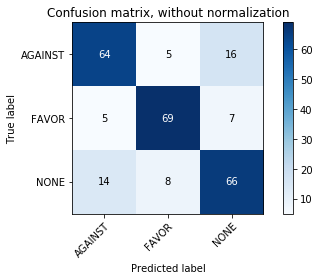

In [16]:
# y_pred, mallet_report = classifier.RandomForest(x_train_orig, x_test_orig, y_train, y_test)
# pprint(mallet_report)

In [ ]:
# y_pred, mallet_report = classifier.RandomForest(x_train, x_test, y_train, y_test)
# pprint(mallet_report)

In [ ]:
# y_pred

/home/ubuntu/anaconda3/envs/torch_custom/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Confusion matrix, without normalization
[[39 24 22]
 [22 42 17]
 [24 29 35]]


/home/ubuntu/anaconda3/envs/torch_custom/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/ubuntu/anaconda3/envs/torch_custom/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/ubuntu/anaconda3/envs/torch_custom/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'SVM_CM': [[39, 24, 22], [22, 42, 17], [24, 29, 35]],
 'SVM_F1_SCORE': 0.45606500737219685,
 'SVM_best_estimator': SVC(C=1000, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
 'SVM_cross_val_score': [0.45738159762550007,
                         0.4649185823754789,
                         0.46728779221409417,
                         0.4658730158730158,
                         0.39610784953250705],
 'SVM_mean_acc': 0.45031376752411917,
 'SVM_std_acc': 0.054638770907525995,
 'test_ccuracy': 0.4566929133858268,
 'train_accuracy': 0.5025466893039049}


/home/ubuntu/anaconda3/envs/torch_custom/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


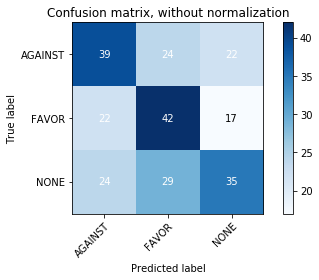

In [17]:
y_pred, mallet_report = classifier.SVMClassifier(x_train, x_test, y_train, y_test)
pprint(mallet_report)

In [ ]:
y_pred

In [ ]:
def plot(X, targets):
    # X has shape [n_documents, 2]
    
    plt.figure(figsize=(16, 9), dpi=120);
    cmap = plt.cm.tab20
    number_of_targets = 3
    
    for i in range(number_of_targets):
        
        label = i
        size = 15.0
        linewidths = 0.5
        edgecolors = 'k'
        color = cmap(i)
        
        plt.scatter(
            X[targets == i, 0], 
            X[targets == i, 1], 
            s=size, c=color, marker='o',
            linewidths=linewidths, edgecolors=edgecolors,
            label=label
        );
    
    leg = plt.legend()
    leg.get_frame().set_alpha(0.3)

In [ ]:
tsne = TSNE(perplexity=200, n_jobs=4)
x_train_vecs = np.array(x_train)
y_train_vecs = np.array(y_train)
X = tsne.fit_transform(x_train_vecs.astype('float64'))

In [ ]:
plot(X, y_train_vecs)

In [ ]:
tsne = TSNE(perplexity=200, n_jobs=4)
x_train_orig = np.array(x_train_orig)
Z = tsne.fit_transform(x_train_orig.astype('float64'))

In [ ]:
plot(Z, y_train_vecs)